<mark> Clara Llòria (218147) and Suman Pan (218352) </mark>
<!-- <span style="color:purple">Clara Lloría (218147) and Suman Pan (218352)</span>. -->
<!-- <mark style="background-color: lightblue"> </mark> -->

# Lab 1: image transformations


The aim of this practical assignment is to provide a first contact with
projective geometry and homogeneous coordinates.  We will first apply different
transformations to an image to get the feel of how does each transform type
looks like.  Then we will see two different methods for image rectification.

You will have to answer the questions and complete the provided code when
necessary as required. Some questions are rather theoretical and eventually
imply some calculations while others are practical questions. **You must
deliver a pdf file with the answers to the questions and the completed ipynb
file with all code cells already executed.**

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img 
import matplotlib.pyplot as plt

## **1. Applying image transformations**

### **1.1 Applying a homography to an image**

Below we provide the function `apply_H` which takes as input an image and a
transformation (specified in a $3\times 3$ matrix `H`) and applies the
desired transformation to the input image. 

**Q1.** Examine and understand the code. Complete the code following 
the directions in the function.

In [2]:
def get_transformed_pixels_coords(I, H, shift=None):
    ys, xs = np.indices(I.shape[:2]).astype("float64")
    if shift is not None:
        ys += shift[1]
        xs += shift[0]
    ones = np.ones(I.shape[:2]) # (400, 337)
    coords = np.stack((xs, ys, ones), axis=2)
    coords_H = (H @ coords.reshape(-1, 3).T).T #? AFTER
    coords_H /= coords_H[:, 2, np.newaxis]
    cart_H = coords_H[:, :2]
    
    return cart_H.reshape((*I.shape[:2], 2))

def apply_H(I, H):
    h, w = I.shape[:2] 
    
    # 1. Homogenize corners
    c1 = np.array([1, 1, 1])
    c2 = np.array([w, 1, 1])
    c3 = np.array([1, h, 1])
    c4 = np.array([w, h, 1])
    
    #transform corners according to H
    # *** TO COMPLETE ***
    #     Compute the transformed homogeneous image corners according to H.
    #     Normalize the homogeneous coordinates so as the third
    #     coordinate is always 1.
    #     Call the transformed corners: Hc1, Hc2, Hc3, Hc4
    
    # 2. Apply H
    Hc1= H.dot(c1) #% transformed corner c1
    Hc2= H.dot(c2) #% transformed corner c2
    Hc3= H.dot(c3) #% transformed corner c3
    Hc4= H.dot(c4) #% transformed corner c4
    
    # 3. Dehomogenize
    Hc1 /= Hc1[2];
    Hc2 /= Hc2[2];
    Hc3 /= Hc3[2];
    Hc4 /= Hc4[2];
        
    # compute extremal transformed corner coordinates
    xmin = np.around(np.amin([Hc1[0], Hc2[0], Hc3[0], Hc4[0]]))
    xmax = np.around(np.amax([Hc1[0], Hc2[0], Hc3[0], Hc4[0]]))
    ymin = np.around(np.amin([Hc1[1], Hc2[1], Hc3[1], Hc4[1]]))
    ymax = np.around(np.amax([Hc1[1], Hc2[1], Hc3[1], Hc4[1]]))
    
    size_x = ceil(xmax - xmin + 1)
    size_y = ceil(ymax - ymin + 1)
    
    # transform image ->using backward
    H_inv = np.linalg.inv(H)

    out = np.zeros((size_y, size_x, 3))
    shift = (xmin, ymin)
    
    interpolation_coords = get_transformed_pixels_coords(out, H_inv, shift=shift)
    interpolation_coords[:, :, [0, 1]] = interpolation_coords[:, :, [1, 0]] 
    interpolation_coords = np.swapaxes(np.swapaxes(interpolation_coords, 0, 2), 1, 2) #Interchange two axes of an array.
    
    # use map_coordinates: Map the input array to new coordinates by interpolation.
    out[:, :, 0] = map_coordinates(I[:, :, 0], interpolation_coords)
    out[:, :, 1] = map_coordinates(I[:, :, 1], interpolation_coords)
    out[:, :, 2] = map_coordinates(I[:, :, 2], interpolation_coords)
  
    return out.astype("uint8")

In [3]:
# Function to create H matrix
def get_H_mat(ang=0,t=[1,1], s=[1,1,1]):
    theta = ang*np.pi/180
    # Create rotation and translation matrix
    R = np.array( [[np.cos(theta),-np.sin(theta),t[0]],
                   [np.sin(theta),np.cos(theta),t[1]],
                   [0 ,0 ,1]])
    
    # Create scaling matrix
    S = np.zeros([3,3])
    np.fill_diagonal(S, s)
    
    H = np.dot(R,S)

    return H

Now we are going to test the completed function `apply_H.m`
with a hierarchy of 2D transformations. 

**Q2.** We want to apply a rotation of $30^o$ to the image. Which is the appropriate
expression of matrix `H` below? Which kind of transformation is it?

<mark> <font size="3"> **Answer:** </mark>
*   The general expression is:
$$ H = \left(\begin{array}{ccc}
    cos(\theta) & sin(\theta) & 0\\
    -sin(\theta) & cos(\theta) & 0 \\
    0 & 0 & 1 \\
   \end{array} \right)
$$

so in this case we have an Isometry transformation, since we are only applying a rotation.


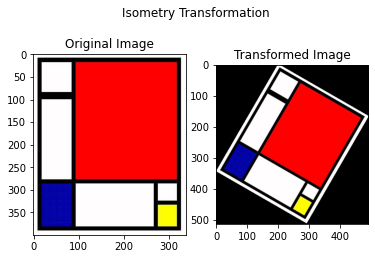

In [4]:
# -- Q2 --
img_path = "./Data/mondrian.jpg"

# Create parameters
I = Image.open(img_path)
ang = 30
# Apply transformation
H = get_H_mat(ang)
It = apply_H(np.array(I), H)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Isometry Transformation')
ax1.set_title('Original Image')
ax2.set_title('Transformed Image')
ax1.imshow(I); ax2.imshow(It)
plt.show()

**Q3.**
We want to apply a rotation of $-70^o$ and a translation of 10 pixels in the
horizontal direction and 350 pixels in the vertical direction.  Which is the
appropriate input `H`? Which kind of transformation is it?  What are the
invariants of this type of transformation?

<mark> <font size="3"> **Answer:** </mark>
*   The appropiate input H we need to use will be:
$$ H = \left(\begin{array}{ccc}
    cos(\theta) & sin(\theta) & tx \\
    -sin(\theta) & cos(\theta) & ty \\
    0 & 0 & 1\\
   \end{array} \right) = 
   \left(\begin{array}{ccc}
    cos(-7/18\pi) & sin(-7/18\pi) & 10 \\
    -sin(-7/18\pi) & cos(-7/18\pi) & 350 \\
    0 & 0 & 1\\
   \end{array} \right)
$$

so in this case we have a Similarity transformation with a scaling factor of 0, since we are only rotating and tranlating.

Finally, the invariants of this type of transformation are the angles, the ratio of lengths and the ratio of two areas.

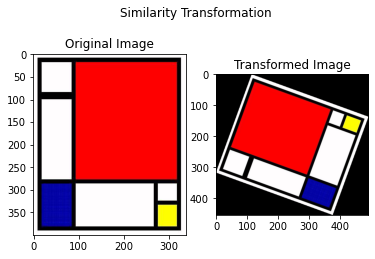

In [5]:
# -- Q3 --
# Create parameters
ang = -70
t = [10,350];

# Transform image
H = get_H_mat(ang, t)
It = apply_H(np.array(I), H)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Similarity Transformation')
ax1.set_title('Original Image')
ax2.set_title('Transformed Image')
ax1.imshow(I); ax2.imshow(It)
plt.show()

**Q4.**
We want to apply a rotation of $10^o$ to the image and a scaling of 1.5 in both
coordinates. Which is the appropriate input `H`? Which kind of
transformation is it?  What are the invariants of this type of transformation?

Add a code cell below that transforms the previous image with the transformations required in Q3 and Q4.

<mark> <font size="3"> **Answer:** </mark>
*   The appropiate input H we need to use will be:
$$ H = 
    \left(\begin{array}{ccc}
    cos(\theta) & sin(\theta) & tx \\
    -sin(\theta) & cos(\theta) & ty \\
    0 & 0 & 1\\
   \end{array} \right) 
   \left(\begin{array}{ccc}
    s_x & 0 & 0 \\
    0 & s_y & 0 \\
    0 & 0 & 1\\
    \end{array} \right) =
\\
   \left(\begin{array}{ccc}
    cos(-1/18\pi) & sin(-1/18\pi) & 1 \\
    -sin(-1/18\pi) & cos(-1/18\pi) & 1 \\
    0 & 0 & 1\\
   \end{array} \right)  \left(\begin{array}{ccc}
    1.5 & 0 & 0 \\
    0 & 1.5 & 0 \\
    0 & 0 & 1\\
   \end{array} \right)
$$

so in this case we also have a Similarity transformation, since we are rotating and scaling, and in this case the translation is [1,1]


The invariants of this type of transformation are angles, ratio of lenghts and ratio of two areas.

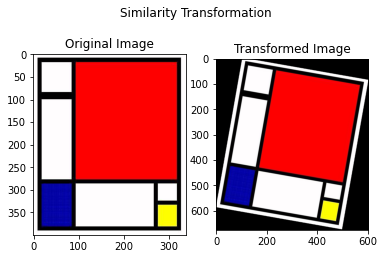

In [6]:
# -- Q4 --
# Create parameters
ang = 10
t = [1,1];
s = [1.5,1.5, 1]

# Transform image
H = get_H_mat(ang, t, s)
It = apply_H(np.array(I), H)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Similarity Transformation')
ax1.set_title('Original Image')
ax2.set_title('Transformed Image')
ax1.imshow(I); ax2.imshow(It)
plt.show()

Now apply the following transformation to the Mondrian image (complete the cell code below):
$$ H = \left(\begin{array}{ccc}
    2 & -1 & 1 \\
    1 & 1 & 3 \\
    0 & 0 & 1 \\
   \end{array} \right)
$$

**Q5.**
Which kind of transformation is it?  What are the invariants of this type of
transformation?


**Q6.**
Use the SVD decomposition (function `np.linalg.svd`) to express the
transformation $H$ as a composition of two rotations, a pure anisotropic
scaling and a pure translation (the rotations may also include a reflection).
Which are the matrices corresponding to each one of the transformations?  Which
is the appropriate order of composition? Apply these matrices to the image in the proper
order, one by one,  with the function `apply_H` and verify that you get the same result than applying all the transformations at the same time using a single matrix.  Provide in the cell code below all
the commands used for this verification.

<mark> <font size="3"> **Answer:** </mark>

In this case we have an Affine transformation, since we are rotating and scaling, but the parallelism is still preserved, so the invariants are the parallel lines, the ratios of parallel length, the ratio of two areas and line at infinity.
    
Then, using the SVD decomposition we can decompse the H matrix as $M=UΣV^T$ applying in this order, namely $\mathbf{{x}'}= M\mathbf{x}$ multiplying from right to left, where:
* $U$ represents the rotation matrix.
* $Σ$ represents the pure anistropic scaling.
* $V^T$ represents the rotation matrix.
And the translation is done by perform normalization of the input data matrix internally in the funtion of SVD.
$\mathbf{{x}'}=H_a\mathbf{x}=\begin{pmatrix}
 M& \vec{t}\\ 
 \vec{0}^{\top}& 1
\end{pmatrix} \mathbf{x}$
    
Where $U$ and $V^T$ are orthonormal matrices that determine vector directions, and ∑ holds the magnitudes of vector directions.

We prove that the matrices are element-wise equals: 
Are they same ? True


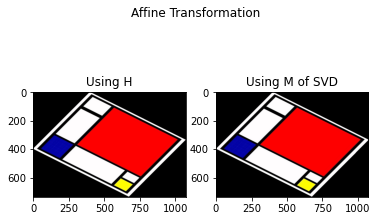

In [7]:
H_new = [[2.0,-1.0,1.0],[1.0,1.0,3.0],[0.0,0.0,1.0]]
It_1 = apply_H(np.array(I), np.array(H_new))

# Decompose H using SVD
u, s, vh = np.linalg.svd(H_new, full_matrices=True)
S = np.zeros([3,3]); np.fill_diagonal( S, s)
# Build H matrix again using the decomposition
H_p = np.dot(u,np.dot(S,vh))
It_svd = apply_H(np.array(I), H_p)

print("We prove that the matrices are element-wise equals: \nAre they same ?",np.allclose(H_new,H_p))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Affine Transformation')
ax1.set_title('Using H')
ax2.set_title('Using M of SVD')
ax1.imshow(It_1); ax2.imshow(It_svd)
plt.show()

### **1.2 Projective transformations (Homographies)**

Apply a projective transformation to the Mondrian image.  Play with matrices similar to 
$$ H = \left(\begin{array}{ccc}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0.001 & 0.001 & 1 \\
   \end{array} \right)
$$
to get the feel of what an homography looks like.

**Q7.**
Specify the matrix $H$ used. What are the invariants of this type of
transformation?

<mark> <font size="3"> **Answer:** </mark>
    
    In this we have projective transformation, and according to the theory is is invariants to
    concurrency, collinearity, order of contact, cross ratio (intersection, tangency, inflections, tangent discontinuities, cusps).
    Where the matrix Hp is a 3 × 3 non-singular matrix, called a homography
$$H_p=\begin{pmatrix}
 h_{11}&h_{12}  &h_{13} \\ 
 h_{21}&h_{22}  &h_{23} \\ 
 h_{31}&h_{32}  &h_{33} 
\end{pmatrix}$$

**Q8.**
Show that an affinity maps points at infinity to points at infinity.

<mark> <font size="3"> **Answer:** </mark>
    Let's define two parallel lines: 
    $$l\_1 = ()$$ $$l\_2 = ()$$
    
    VOY A DEJARLO AHI POR AHORA, MEJOR PREGUNTAR PRIMERO

**Q9.**
Show that a projectivity maps points at infinity to finite points.

<mark> <font size="3"> **Answer:** </mark>

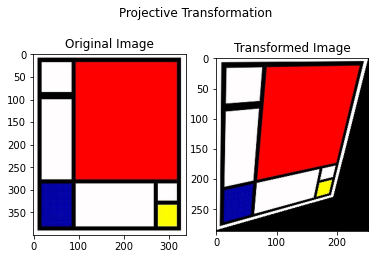

In [8]:
H = np.identity(3) # complete
H[2,:]=[0.001,0.001,1]

It = apply_H(np.array(I), H)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Projective Transformation')
ax1.set_title('Original Image')
ax2.set_title('Transformed Image')
ax1.imshow(I); ax2.imshow(It)
plt.show()

## **2. Image Rectification**

We are going to test two image rectification methods.  

### **2.1 Interactive method**
In
the first approach we are going to remove the projective distortion from a
perspective image of a plane (flat surface in the 3D world). The key idea is to select four coplanar points
that should be mapped to a rectangle.

**Q10.** Use the code below to choose the four points marked in the image below 
and obtain their coordinates in pixels. (You will have to install the opencv library: `pip install opencv-python`)

![4points](Data/marked_points.jpg)

In [9]:
# !pip install opencv-python

In [10]:
# import cv2
# import os
# def show_cords(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print(f'{x},{y}'             )
#         imgCopy = image.copy()
#         cv2.putText(imgCopy, f'{x},{y}', (20, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 255, 0))
#         cv2.imshow(window_name, imgCopy)
# path = "./Data/metro2.png"
# assert os.path.exists(path), f'File doesnt exist'
# # Reading an image in default mode
# image = cv2.imread(path)
# # Window name in which image is displayed
# window_name = 'image'
# cv2.namedWindow(window_name, cv2.WINDOW_GUI_NORMAL )
# cv2.setMouseCallback(window_name, show_cords)
# # Using cv2.imshow() method
# # Displaying the image
# cv2.imshow(window_name, image)
# # while True:
# #     cv2.imshow(window_name, image)
# #     key=cv2.waitKey(0)
# #     if key == ord('q'):
# #         break
# #     # closing all open windows

# cv2.destroyAllWindows()
# cv2.destroyWindow(window_name)

**Q11.** Choose the coordinates of the four points where the original points should be
mapped to in order to form a rectangle, i.e. the lines joining these four
points should form right angles. Create two $3\times 4$ matrices, `X` and `Y`, with the homogeneous
coordinates of the four selected points and the four transformed points,
respectively. Complete the code below accordingly.

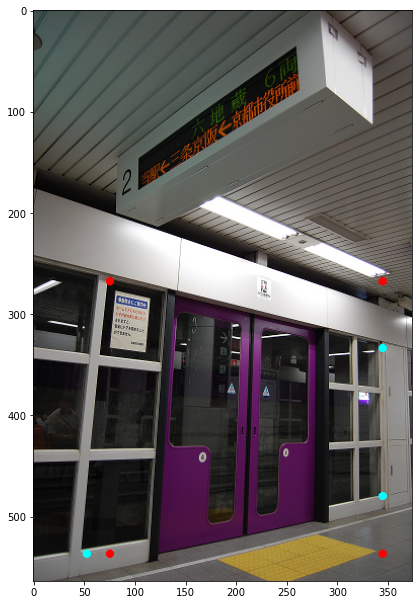

In [11]:
# Question 10: p1, p2, p3, and p4 are the coordinates you chose in Q10

p1= [72,264,1]
p2 = [341,330,1]
p3= [341,476,1]
p4 = [49,533,1]

# Question 11
X = [p1, p2, p3, p4]
X = np.array(X).T
np.shape(X)

p1_p = [72, 264, 1]
p2_p = [341, 264, 1]
p3_p = [341, 533, 1]
p4_p = [72, 533, 1]
Y = [p1_p, p2_p, p3_p, p4_p]
Y = np.array(Y).T

# Draw selected points
import matplotlib
img_path = "./Data/metro2.png"
I = Image.open(img_path)

canv2 = ImageDraw.Draw(I)
for i in range(4):
    canv2.ellipse((X[0,i], X[1,i], X[0,i]+7, X[1,i]+7), fill = 'cyan', outline ='cyan')
    canv2.ellipse((Y[0,i], Y[1,i], Y[0,i]+7, Y[1,i]+7), fill = 'red', outline ='red')


from matplotlib import pyplot as plt
plt.imshow(I)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

The purpose now is to find the homography `H` that relates the two sets of
points, encoded in the matrices `X` and `Y`, by using the normalised Direct Linear Transformation (DLT) algorithm.
This algorithm is implemented in the provided function `DLT_homography` below, there are two missing parts that you have to complete. The
matrix `H` is obtained by calling this function with the two matrices `X` and `Y` of
homogeneous coordinates as inputs.

**Q12.** Provide the completed code (also in the pdf document). 
Which is the matrix `H` obtained?

In [12]:
# code homography ----- solution
def Normalization(x):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2).
    Input
    -----
    x: the data to be normalized (3 x N array)
    Output
    ------
    Tr: the transformation matrix (translation plus scaling)
    x: the transformed data
    '''

    x = np.asarray(x)
    x = x  / x[2,:]
    
    m, s = np.mean(x, 1), np.std(x)
    s = np.sqrt(2)/s;
 
    Tr = np.array([[s, 0, -s*m[0]], [0, s, -s*m[1]], [0, 0, 1]])


    xt = Tr @ x
        
    return Tr, xt

def DLT_homography(points1, points2):
    
    # Normalize points in both images
    T1, points1n = Normalization(points1)
    T2, points2n = Normalization(points2)
    
    A_old = []
    #For each correspondence compute A_i
    for i in range(points1.shape[1]):
        a11= np.dot(-points2n[2,i], points1n[:,i].T)
        a12 = np.zeros(3)
        a13 = np.dot(points2n[0,i], points1n[:,i].T)

        a21 = np.zeros(3)
        a22 = np.dot(-points2n[2, i], points1n[:,i].T)
        a23 = np.dot(points2n[1, i], points1n[:,i].T)
        A_i = np.concatenate((a11, a12, a13, a21, a22, a23))
        A_i = A_i.reshape(2,9)
        A_old.append(A_i)

    A = np.array(A_old).reshape(8,9)
    U, d, Vt = np.linalg.svd(A)
    
    # Extract homography (last line of Vt)
    L = Vt[-1, :] / Vt[-1, -1]
    H = L.reshape(3, 3)
    
    # Denormalise
    H = np.dot(np.linalg.inv(T2), np.dot(H, T1))
    
    return H

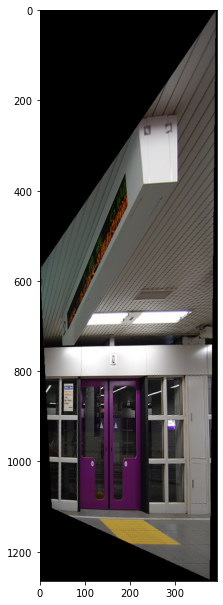

In [13]:
img_path = "./Data/metro2.png"
I = Image.open(img_path)
H = DLT_homography(X,Y)
It = apply_H(np.array(I), H)

plt.imshow(It)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **2.2 Stratified method**

In this part we will test a method for image rectification which works in two steps: affine and metric rectification. We will work with the same image as before.

#### **2.2.1 Affine rectification**

This first step uses the line at infinity. <mark>The rectification is based on transforming the identified 
image of the line at infinity to its canonical position of $\ell_{\infty} = (0, 0, 1)^T$.</mark> 
This is done by a projective transformation built <mark>from the coordinates of the imaged 
line at infinity, $\ell = (\ell_1, \ell_2, \ell_3)^T$</mark>, provided that $\ell_3 \neq 0$. 
The idea 
is illustrated in the following figure:

![Title](Data/fig1.jpg)

We are going to compute $\ell$, the imaged $\ell_{\infty}$, as the intersection 
of the two pair of lines formed by the four selected points in the previous exercise.
For that, we are going to use the dual properties of homogeneous points and lines that define the line joining two points and the intersection of lines.

The first approach to compute the line at infinity will be to use the four points manually selected previously. 

**Q13.**
Compute the vector `l1` representing the line that joins the two upper selected points.
Compute the vector `l2` representing the line that joins the two lower selected points.
Compute the vector `l3` representing the line that joins the two left selected points.
Compute the vector `l4` representing the line that joins the two right selected points.

SUGGESTION: You may use the numpy function `cross`.


In [14]:
# Manually chosen rectificated points
p1 = [72, 264, 1]
p2 = [341, 264, 1]
p3 = [341, 533, 1]
p4 = [72, 533, 1]

l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p1, p4)
l4 = np.cross(p2, p3)

You may visualize the computed lines to check that your result is correct. 
Use the following commands to visualize the lines.

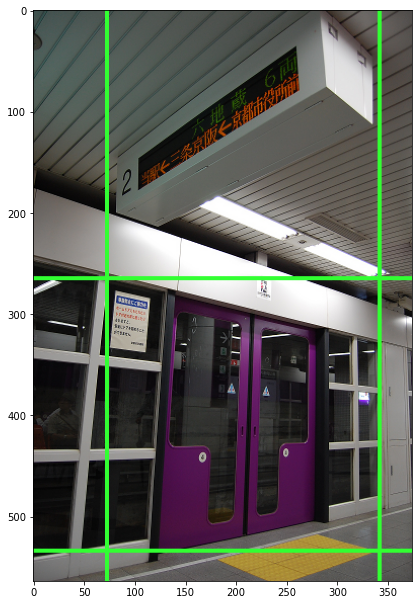

In [15]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)

line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

plt.imshow(I)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

**Q14.** 
Compute the point where the lines `l1` and `l2` intersect. 
Compute the point where the lines `l3` and `l4` intersect. 
These are the vanishing points.

<mark> <font size="3"> **Answer:** </mark>
    
The expressions for the four lines are:
    $$L\_1 = (72,264,1) x (341, 330, 1)$$
    $$L\_2 = (341, 476, 1) x (49, 533, 1)$$
    $$L\_3 =  (72,264,1) x (49, 533, 1) $$
    $$L\_4 = (341, 330, 1) x (341, 476, 1)$$

**Q15.** 
Compute the imaged line at infinity, $\ell$, from 
the two vanishing points previously computed.


**Q16.** 
Give the expression of a matrix `H_aff_rect` that maps the line 
$\ell$ to the line $\ell_{\infty} = (0, 0, 1)^T$.


Complete the code below according to the previous answers and rectify the image by applying the computed homography. Compute also the transformed lines in order to visualize them as well.

In [16]:
np.identity(3) * np.identity(3)*3

# print(np.normalize(l1))

array([[3., 0., 0.],
       [0., 3., 0.],
       [0., 0., 3.]])

In [17]:
v_1 = np.cross(l1, l2)
v_2 = np.cross(l3, l4)

# compute the image of the line at infinity
linf = np.cross(v_1,v_2)

# homography that affinely rectifies the image
rec_M = np.identity(3) 
rec_M[2,:]=linf

H = DLT_homography(X,Y)
Ha = H # the afinity matrix is the previous one???

H_aff_rect = Ha * rec_M  # ... complete

l_inf = 1/H_aff_rect.T * linf # ???
# print(linf)
# H_aff_rect

# compute the transformed image
I_aff_rect = # ... complete

# compute the transformed lines
lr1, lr2, lr3, lr4 = # ... complete


SyntaxError: invalid syntax (Temp/ipykernel_3288/156171631.py, line 21)

In [ ]:
# show the transformed lines in the transformed image
I_tr = Image.fromarray(I_aff_rect, 'RGB')
size = I_tr.size
canv = ImageDraw.Draw(I_tr)
line_draw(lr1, canv, size)
line_draw(lr2, canv, size)
line_draw(lr3, canv, size)
line_draw(lr4, canv, size)

plt.imshow(I_tr)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

**Q17.** Is the resulting image as expected? Why this time the angle between 
perpendicular lines in the real world is not right?

Now, instead of manually selecting the projected parallel lines in the image we will use the vanishing points estimated by an automatic method for detecting vanishing points in urban scenes. It is based on the detection of line segments in the image and then identifying sets of converging segments and their intersection point by finding point alignments in a proper different space (more details, online demo and code available in the webage of the related publication http://www.ipol.im/pub/art/2017/148/).
The result of the method applied to our image of interest is provided in the folder called 'vanishing_points'. The algorithm has detected four different vanishing points: their coordinates are given in matrix `vps` read in the code below. The lines corresponding to each of these points are depicted in the provided images in the folder 'vanishing_points'.

**Q18.**
Identify the proper pair of vanishing points to affinely rectify the image (justify your answer) and provide the code to obtain the rectified image with the new estimated vanishing points.

In [ ]:
import scipy.io as sio
mat_content = sio.loadmat('./vanishing_points/vps.mat')
vps=mat_content['vps']
print(vps)

# complete the code that affinely rectifies the image and shows the transformed image ...

#### **2.2.2 Metric rectification (optional)**

As an optional task you can code the metric rectification step by using the images of two pairs of orthogonal lines. For that, you can assume that the rectangle is actually a square.